In [12]:
import pandas as pd
import numpy as np
import torch
import torch.nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import rankdata
from tqdm import tqdm
import re
import sys, os
sys.path.append('../../src/')

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from operator import itemgetter
from multiprocessing import Pool
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

import bmk_beeline as bmk
import g_glad, g_admm, genie3, keller
import simulator_linear as sim
import sklearn
import seaborn as sns
from collections import defaultdict



<module 'simulator_linear' from '/Users/ziqizhang/Documents/pace/DynGRN/simulator/linearODE/simulator_linear.py'>

In [2]:
def preprocess(counts): 
    libsize = np.median(np.sum(counts, axis = 1))
    counts = counts / np.sum(counts, axis = 1)[:,None] * libsize
        
    counts = np.log1p(counts)
    return counts

def kendalltau(pt_pred, pt_true):
    from scipy.stats import kendalltau
    pt_true = pt_true.squeeze()
    pt_pred = pt_pred.squeeze()
    tau, p_val = kendalltau(pt_pred, pt_true)
    return tau

def kernel_band(bandwidth, ntimes, truncate = None):
    # bandwidth decide the shape (width), no matter the length ntimes
    t = (np.arange(ntimes)/ntimes).reshape(ntimes,1)
    tdis = np.square(pdist(t))
    mdis = 0.5 * bandwidth * np.median(tdis)
    
    K = squareform(np.exp(-tdis/mdis))+np.identity(ntimes)
    
    if truncate is not None:
        cutoff = mdis * truncate
        mask = (squareform(tdis) < cutoff).astype(int)
        K = K * mask
        
    return K/np.sum(K,axis=1)[:,None]

In [35]:
import importlib 
importlib.reload(sim)
exp_data_cells1, gt_adj1 = sim.run_simulator(ncells = 10, ngenes=18,ntfs=12,tmax=75, mode = "TF-target", nchanges=10, change_stepsize=1500, alp = 10, bet = 5, integration_step_size = 0.01)
exp_data_cells2, gt_adj2 = sim.run_simulator(ncells = 10, ngenes=18,ntfs=12,tmax=1, mode = "TF-target", nchanges=10, change_stepsize=1500, alp = 10, bet = 5, integration_step_size = 0.001)
X1 = preprocess(exp_data_cells1.T)
X2 = preprocess(exp_data_cells2.T)

(7500, 18, 18)
(7500, 18, 18)
(1000, 18, 18)
(1000, 18, 18)


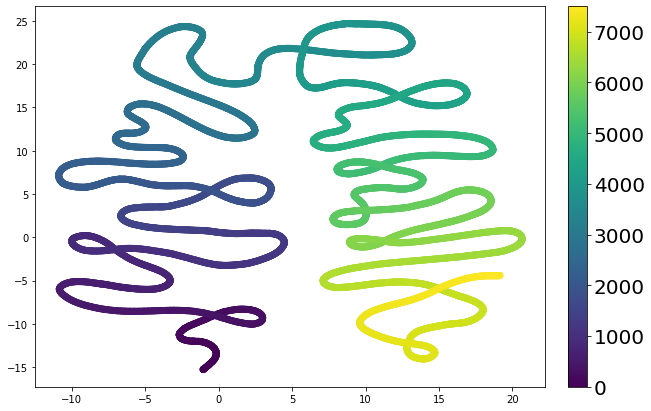

In [36]:
from umap import UMAP
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
umap_op = UMAP(n_components = 2)
x_umap = umap_op.fit_transform(X1)
fig = plt.figure(figsize = (10, 7))
ax = fig.add_subplot()
pic = ax.scatter(x_umap[:,0], x_umap[:,1], c = np.arange(x_umap.shape[0]))
cbar = fig.colorbar(pic, fraction=0.046, pad=0.04, ax = ax)
cbar.ax.tick_params(labelsize = 20)

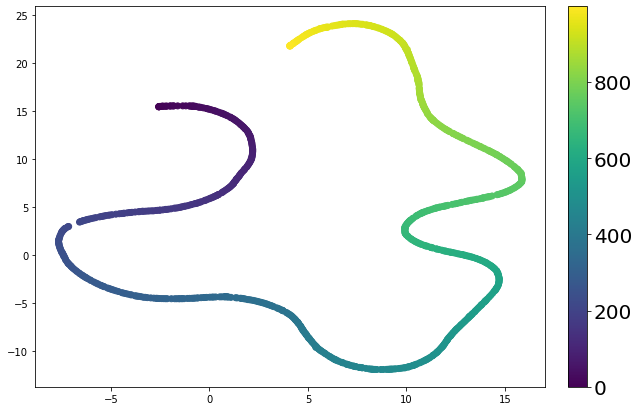

In [39]:
from umap import UMAP
import matplotlib.pyplot as plt
umap_op = UMAP(n_components = 2)
x_umap = umap_op.fit_transform(X2)
fig = plt.figure(figsize = (10, 7))
ax = fig.add_subplot()
pic = ax.scatter(x_umap[:,0], x_umap[:,1], c = np.arange(x_umap.shape[0]))
cbar = fig.colorbar(pic, fraction=0.046, pad=0.04, ax = ax)
cbar.ax.tick_params(labelsize = 20)

In [46]:
import importlib 
importlib.reload(sim)
exp_data_cells1, gt_adj1 = sim.run_simulator(ncells = 10, ngenes=18,ntfs=12,tmax=75, mode = "TF-target", nchanges=10, change_stepsize=1500, alp = 10, bet = 5, integration_step_size = 0.01)
exp_data_cells2, gt_adj2 = sim.run_simulator(ncells = 10, ngenes=18,ntfs=12,tmax=1, mode = "TF-target", nchanges=10, change_stepsize=1500, alp = 10, bet = 5, integration_step_size = 0.001)
# X1 = preprocess(exp_data_cells1.T)
# X2 = preprocess(exp_data_cells2.T)
X1 = exp_data_cells1.T
X2 = exp_data_cells2.T

(7500, 18, 18)
(7500, 18, 18)
(1000, 18, 18)
(1000, 18, 18)


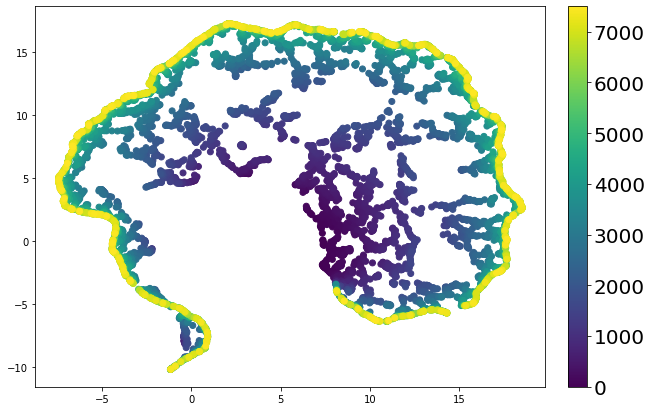

In [47]:
from umap import UMAP
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
umap_op = UMAP(n_components = 2)
x_umap = umap_op.fit_transform(X1)
fig = plt.figure(figsize = (10, 7))
ax = fig.add_subplot()
pic = ax.scatter(x_umap[:,0], x_umap[:,1], c = np.arange(x_umap.shape[0]))
cbar = fig.colorbar(pic, fraction=0.046, pad=0.04, ax = ax)
cbar.ax.tick_params(labelsize = 20)

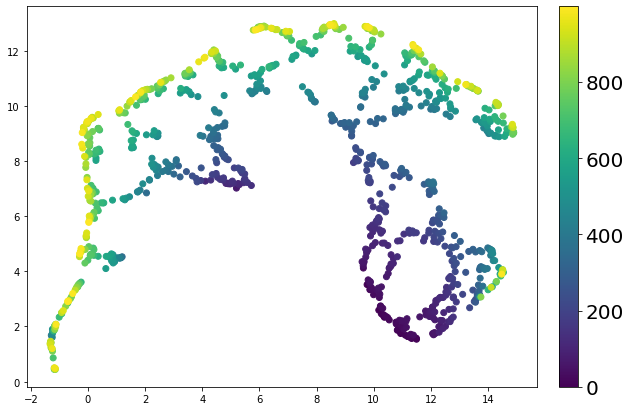

In [48]:
from umap import UMAP
import matplotlib.pyplot as plt
umap_op = UMAP(n_components = 2)
x_umap = umap_op.fit_transform(X2)
fig = plt.figure(figsize = (10, 7))
ax = fig.add_subplot()
pic = ax.scatter(x_umap[:,0], x_umap[:,1], c = np.arange(x_umap.shape[0]))
cbar = fig.colorbar(pic, fraction=0.046, pad=0.04, ax = ax)
cbar.ax.tick_params(labelsize = 20)

In [8]:
ngenes, ntimes = exp_data_cells.shape

X = preprocess(exp_data_cells.T)
X = StandardScaler().fit_transform(X)
# X = X - np.mean(X, axis = 0)
print("Raw TimePoints: {}, no.Genes: {}".format(X.shape[0],X.shape[1]))

Raw TimePoints: 7500, no.Genes: 18


In [10]:
gt_adj = gt_adj * (1 - np.eye(ngenes))

# transcription factor
tf = list(set(np.nonzero(gt_adj[0])[0]))

gt_adj_sym = gt_adj + np.transpose(gt_adj,(0,2,1))

In [11]:
mask = np.zeros((ngenes, ngenes))
ntfs = 12
# mark probable interactions
mask[:ntfs, :ntfs] = 1
mask[ntfs:, ntfs:] = 1

In [12]:
# In[3] convert the gene expression matrix to (nsegs, nsamples, ngenes), the segment length is nsamples, output X
# generate the graph index for each segment, output graph_idx of the shape (nsegs, )
nsamples = 5
nsegs = ntimes//nsamples
X_seg = X.reshape(nsegs,nsamples,ngenes)

# test model without TF
bandwidth = 0.1
K = kernel_band(bandwidth, nsegs) #ntime > nsegs

max_iters = 100
glad_batch = g_glad.G_glad_batch(X = X_seg, K = K, pre_cov = None) #best hyper: rho = 1.e-4 lamb = 5.e-2 # lamb = 0.1 , rho = 10
# glad_thetas size is (nsegs, ngenes, ngenes)
glad_thetas_seg = glad_batch.train(max_iters = max_iters, n_intervals = max_iters, lamb = 1e-4 , rho = 1, theta_init_offset = 0.1)
# reverse it back to (ntimes, ngenes, ngenes)
glad_thetas_seg = np.repeat(glad_thetas_seg[:, None, :, :], repeats = nsamples, axis = 1).reshape((ntimes, ngenes, ngenes))
# np.save(file = result_dir + "glad_thetas_seg.npy", arr = glad_thetas_seg)

# test model with TF
bandwidth = 0.1
K = kernel_band(bandwidth, nsegs) #ntime > nsegs

max_iters = 100
glad_batch = g_glad.G_glad_batch(X = X_seg, K = K, pre_cov = None, TF = tf) #best hyper: rho = 1.e-4 lamb = 5.e-2 # lamb = 0.1 , rho = 10
# glad_thetas size is (nsegs, ngenes, ngenes)
glad_thetas_seg_tf = glad_batch.train(max_iters = max_iters, n_intervals = max_iters, lamb = 1e-4, beta = 100, rho = 1, theta_init_offset = 0.1)
# reverse it back to (ntimes, ngenes, ngenes)
glad_thetas_seg_tf = np.repeat(glad_thetas_seg_tf[:, None, :, :], repeats = nsamples, axis = 1).reshape((ntimes, ngenes, ngenes))
glad_thetas_seg_tf = glad_thetas_seg_tf*(1 - mask)

In [13]:
# In[4] building weighted covariance matrix, output is empir_cov of the shape (ntimes, ngenes, ngenes)
sample = torch.FloatTensor(X)

bandwidth = 1

empir_cov = torch.zeros(ntimes, ngenes, ngenes)
K = kernel_band(bandwidth, ntimes)
K_trun = kernel_band(bandwidth, ntimes, truncate = 1.5)

# building weighted covariance matrix, output is empir_cov of the shape (ntimes, ngenes, ngenes)
for time in range(ntimes):
    weight = K_trun[time, :]
    assert np.abs(np.sum(weight) - 1) < 1e-6

    bin_weight = torch.FloatTensor((weight > 0).astype(int))
    sample_mean = torch.sum(sample * weight[:, None], axis = 0)
#     sample_mean = torch.sum(sample * (bin_weight/torch.sum(bin_weight))[:, None], axis = 0)

    norm_sample = sample - sample_mean[None, :]
    empir_cov[time] = torch.sum(torch.bmm(norm_sample[:,:,None], norm_sample[:,None,:]) * weight[:,None, None], dim=0)
        
# test model without TF
max_iters = 100
glad_thetas_weighted = np.zeros((ntimes,ngenes,ngenes))

for time in range(ntimes):
    #X > X[:,None,:]
    glad_single = g_glad.G_glad(X = X[:,None,:], K = K, pre_cov = empir_cov) #best hyper: rho = 1.e-4 lamb = 5.e-2 # lamb = 0.1 , rho = 10
    glad_thetas_weighted[time] = glad_single.train(t = time, max_iters = max_iters, n_intervals = max_iters, lamb = 1e-4 , rho = 1, theta_init_offset = 0.1)

# test model with TF
max_iters = 100
glad_thetas_weighted_tf = np.zeros((ntimes,ngenes,ngenes))

for time in range(ntimes):
    glad_single = g_glad.G_glad(X = X[:,None,:], K = K, pre_cov = empir_cov, TF = tf) #best hyper: rho = 1.e-4 lamb = 5.e-2 # lamb = 0.1 , rho = 10
    glad_thetas_weighted_tf[time] = glad_single.train(t = time, max_iters = max_iters, n_intervals = max_iters, beta = 100, lamb = 1e-4 , rho = 1, theta_init_offset = 0.1)
glad_thetas_weighted_tf = glad_thetas_weighted_tf*(1 - mask)

In [14]:
# In[6] Run Genie3 (weighted = False, Single Estimation)
X_genie = X.reshape(ntimes, ngenes)
# genie_theta of the shape (ntimes, ngenes, ngenes)
genie_theta = genie3.GENIE3(X_genie, gene_names=None, regulators='all',tree_method='RF',K='sqrt',ntrees=1000,nthreads=1)
genie_theta = np.repeat(genie_theta[None, :, :],ntimes,axis=0)

Tree method: RF, K: sqrt, Number of trees: 1000 



In [15]:
# In[7] summarize the score
AUPRC = pd.DataFrame(columns =["kendell","cosine","model","time"])

In [16]:
# convert to absolute value
genie_theta = np.abs(genie_theta)
glad_thetas_seg = np.abs(glad_thetas_seg)
glad_thetas_seg_tf = np.abs(glad_thetas_seg_tf)
glad_thetas_weighted = np.abs(glad_thetas_weighted)
glad_thetas_weighted_tf = np.abs(glad_thetas_weighted_tf)

gt_adj = np.abs(gt_adj)
gt_adj_sym = np.abs(gt_adj_sym)

model: Random, median: -0.029994550309510943
model: Genie3, median: 0.07373095703429196
model: AM (segment), median: 0.022324863179971965
model: AM (segment & TF), median: 0.5047050419185319
model: AM (sliding window), median: 0.08396362719951177
model: AM (sliding window & TF), median: 0.5095824098779888
model: Random, median: -0.009371591790205108
model: Genie3, median: 0.19822470711076096
model: AM (segment), median: 0.22630735930061519
model: AM (segment & TF), median: 0.5554790979830552
model: AM (sliding window), median: 0.19165045294372318
model: AM (sliding window & TF), median: 0.5205125232808662


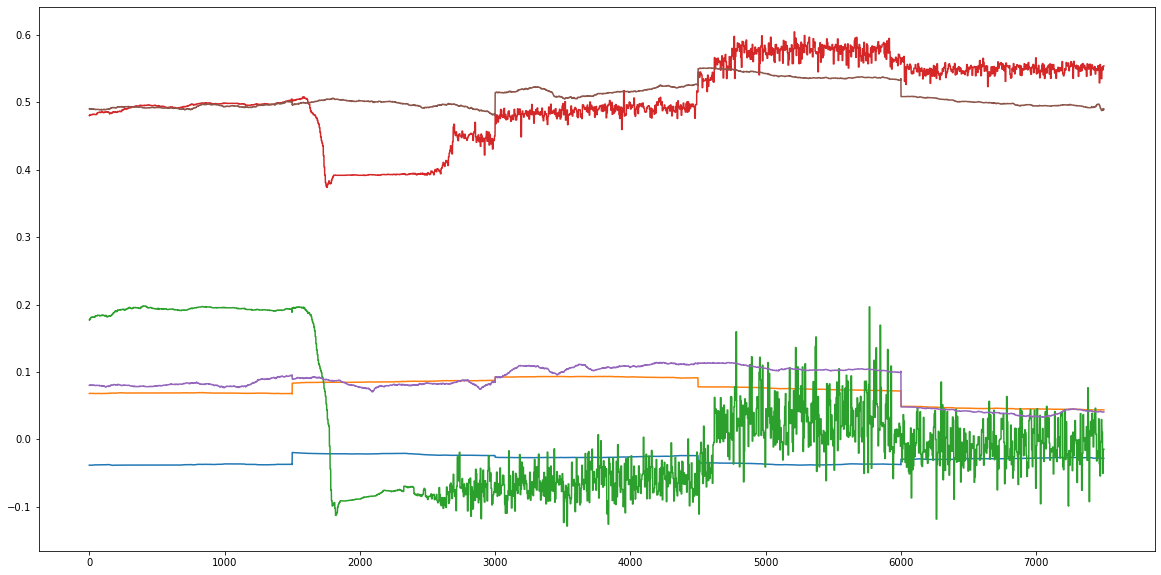

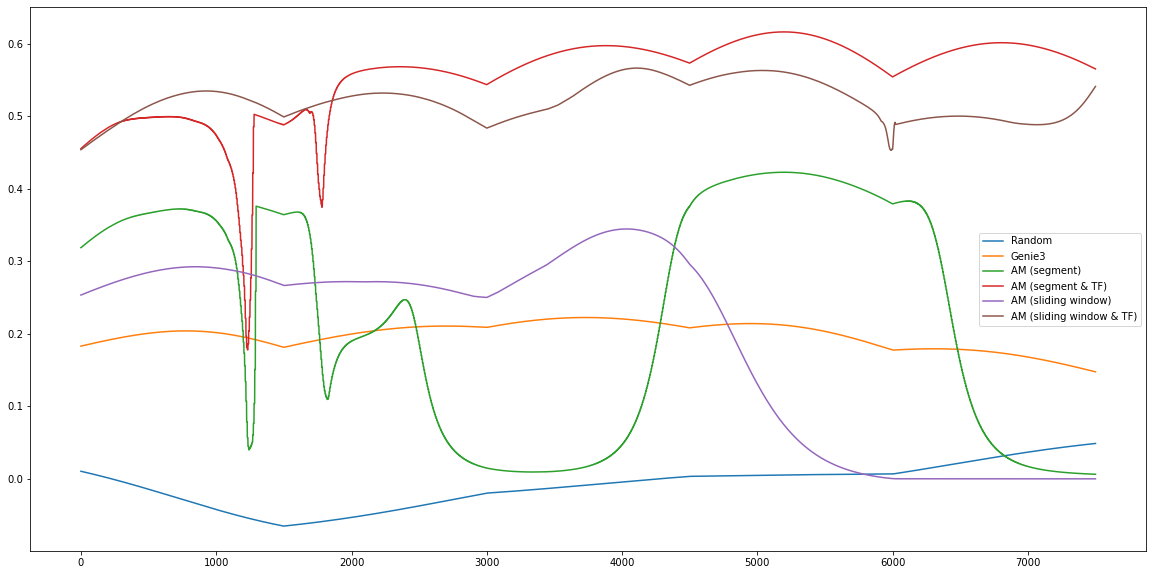

In [17]:
for time in range(0, ntimes):
    np.random.seed(0)

    # random baseline
    thetas_rand = np.random.randn(ngenes,ngenes)
    rand_tau = kendalltau(np.abs(thetas_rand), gt_adj[time])
    rand_cos = np.dot(thetas_rand.reshape(-1), gt_adj[time].reshape(-1))/(np.linalg.norm(thetas_rand.reshape(-1))*np.linalg.norm(gt_adj[time].reshape(-1)))

    # genie3 baseline
    genie_tau = kendalltau(genie_theta[time], gt_adj[time])
    genie_cos = np.dot(genie_theta[time].reshape(-1), gt_adj[time].reshape(-1))/(np.linalg.norm(genie_theta[time].reshape(-1))*np.linalg.norm(gt_adj[time].reshape(-1)))
#     genie_prec_auc  = np.sum(genie_prec) / len(genie_prec)
#     genie_recall_auc = np.sum(genie_recall) / len(genie_recall)

    # segmented covariance matrix  #kendall tau - symmetric vs asymmetric matrix > need to match both to symmetric matrix (gt_adj to symmetric)
    glad_seg_tau = kendalltau(glad_thetas_seg[time], gt_adj_sym[time])
    glad_seg_cos = np.dot(glad_thetas_seg[time].reshape(-1), gt_adj_sym[time].reshape(-1))/(np.linalg.norm(glad_thetas_seg[time].reshape(-1))*np.linalg.norm(gt_adj_sym[time].reshape(-1)))

#     glad_seg_prec_auc  = np.sum(glad_seg_prec) / len(glad_seg_prec)
#     glad_seg_recall_auc = np.sum(glad_seg_recall) / len(glad_seg_recall)

    # segmented covariance matrix with TF
    glad_seg_tf_tau = kendalltau(glad_thetas_seg_tf[time], gt_adj_sym[time])
    glad_seg_tf_cos = np.dot(glad_thetas_seg_tf[time].reshape(-1), gt_adj_sym[time].reshape(-1))/(np.linalg.norm(glad_thetas_seg_tf[time].reshape(-1))*np.linalg.norm(gt_adj_sym[time].reshape(-1)))
#     glad_seg_tf_prec_auc  = np.sum(glad_seg_tf_prec) / len(glad_seg_tf_prec)
#     glad_seg_tf_recall_auc = np.sum(glad_seg_tf_recall) / len(glad_seg_tf_recall)

    # weighted covariance matrix
    glad_weighted_tau = kendalltau(glad_thetas_weighted[time], gt_adj_sym[time])
    glad_weighted_cos = np.dot(glad_thetas_weighted[time].reshape(-1), gt_adj_sym[time].reshape(-1))/(np.linalg.norm(glad_thetas_weighted[time].reshape(-1))*np.linalg.norm(gt_adj_sym[time].reshape(-1)))
#     glad_weighted_prec_auc  = np.sum(glad_weighted_prec) / len(glad_weighted_prec)
#     glad_weighted_recall_auc = np.sum(glad_weighted_recall) / len(glad_weighted_recall)

    # weighted covariance matrix with TF
    glad_weighted_tf_tau = kendalltau(glad_thetas_weighted_tf[time], gt_adj_sym[time])
    glad_weighted_tf_cos = np.dot(glad_thetas_weighted_tf[time].reshape(-1), gt_adj_sym[time].reshape(-1))/(np.linalg.norm(glad_thetas_weighted_tf[time].reshape(-1))*np.linalg.norm(gt_adj_sym[time].reshape(-1)))
#     glad_weighted_tf_prec_auc  = np.sum(glad_weighted_tf_prec) / len(glad_weighted_tf_prec)
#     glad_weighted_tf_recall_auc = np.sum(glad_weighted_tf_recall) / len(glad_weighted_tf_recall)
    
    # linear regression
#     regression_prec, regression_recall, _, _, regression_auprc, _, _ = bmk.compute_auc(regression_thetas[time], gt_adj[time])
#     regression_prec_auc  = np.sum(regression_prec) / len(regression_prec)
#     regression_recall_auc = np.sum(regression_recall) / len(regression_recall)

    # neural regression
#     regression_neural_prec, regression_neural_recall, _, _, regression_neural_auprc, _, _ = bmk.compute_auc(regression_thetas_neural[time], gt_adj[time])
#     regression_neural_prec_auc  = np.sum(regression_neural_prec) / len(regression_neural_prec)
#     regression_neural_recall_auc = np.sum(regression_neural_recall) / len(regression_neural_recall)

    AUPRC = AUPRC.append({"kendell": rand_tau,"cosine":rand_cos, "model":"Random", "time":time}, ignore_index=True)
    AUPRC = AUPRC.append({"kendell": genie_tau,"cosine":genie_cos, "model":"Genie3", "time":time}, ignore_index=True)
    AUPRC = AUPRC.append({"kendell": glad_seg_tau,"cosine":glad_seg_cos, "model":"AM (segment)", "time":time}, ignore_index=True)
    AUPRC = AUPRC.append({"kendell": glad_seg_tf_tau,"cosine":glad_seg_tf_cos, "model":"AM (segment & TF)", "time":time}, ignore_index=True)
    AUPRC = AUPRC.append({"kendell": glad_weighted_tau,"cosine":glad_weighted_cos, "model":"AM (sliding window)", "time":time}, ignore_index=True)
    AUPRC = AUPRC.append({"kendell": glad_weighted_tf_tau,"cosine":glad_weighted_tf_cos, "model":"AM (sliding window & TF)", "time":time}, ignore_index=True)
    
# In[8]
fig = plt.figure(figsize = (20, 10)) #num sample = 1500
ax = fig.add_subplot()

for model in ["Random", "Genie3", "AM (segment)", "AM (segment & TF)", "AM (sliding window)", "AM (sliding window & TF)"]:
    AUPRC_sub = AUPRC[AUPRC["model"] == model]
    ax.plot(np.arange(ntimes), AUPRC_sub["kendell"], label = model)
    print("model: " + model + ", median: " + str(np.mean(AUPRC_sub["kendell"])))
    # ax.axhline(y = np.median(AUPRC["AUPRC Ratio"]), color = "orange", alpha = 0.75)

fig = plt.figure(figsize = (20, 10)) #num sample = 1500
ax = fig.add_subplot()

for model in ["Random", "Genie3", "AM (segment)", "AM (segment & TF)", "AM (sliding window)", "AM (sliding window & TF)"]:
    AUPRC_sub = AUPRC[AUPRC["model"] == model]
    ax.plot(np.arange(ntimes), AUPRC_sub["cosine"], label = model)
    ax.legend()
    print("model: " + model + ", median: " + str(np.mean(AUPRC_sub["cosine"])))